# NSQIP - Stepwise Regression
---

Regressing on all of our predictors at once will tend to produce an over-fitted model. A traditional approach to this is to use a stepwise selection procedure, fitting individual best-fitting terms in sequence and adding them to build up a model in an interative fashion. These models are pretty common in the literature, but statisticians tend not to like them for a variety of reasons. Some of these are technical, but a pretty basic reason is that doing dozens of repeated statistical tests makes the meaning of each statistical test less valid.

Regardless, we'll fit a stepwise logistic regression model here. To be clear, our model is of the form: 

$$P(y|x) = \frac{1}{1 + e^{-(\beta_0 + \sum_{i}\beta_i x_i)}} $$

... where $x$ is a vector of predictors, and $\beta$ is a vector of coefficients. For variable selection at each step, we'll take the new model (produced by either adding a variable or dropping one) that provides the biggest reduction of the [Akaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion). We stop making changes when no addition or removal of a variable reduces the AIC.

We'll try to apply some of the modern bootstrapping technology here to define confidence intervals and estimate model performance. Our strategy will be
 - Divide the data into training and testing sets.
 - Fit a Stepwise Regression to the training set.
 - Use a bootstrap procedure to determine confidence intervals for the coefficients.
 - Check performance on the testing set.

Begin with imports of key libraries, and load the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from stepwiseLogisticRegression import stepwiseLogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
import sklearn.metrics as sklm
import random
import warnings 
import math
# warnings.filterwarnings("ignore") # Ignore annoying warnings

dataDir = './Data/'
mungedFileName = dataDir + 'mungedData.pkl'

cdf = pd.read_pickle(mungedFileName)

Next, determine which CPT codes we'll use.

In [2]:
# CPT codes were munged to numeric values
CPTcodes = cdf.loc[:,'CPT']

# Print some data on all case categories in our dataset
print('--- Achilles operative repair ---')
keepCPT = [27650,27652,27654]
caseCounts = [(eachCPT, list(CPTcodes).count(eachCPT)) for eachCPT in keepCPT]
for aCPT, aCount in caseCounts:
    print('CPT: %d Cases: %d' % (aCPT, aCount))
print('--- Total: %d ---\n' % sum([each[1] for each in caseCounts]))
    

print('--- Calcaneus operative repair ---')
keepCPT = [28406,28415,28420] 
caseCounts = [(eachCPT, list(CPTcodes).count(eachCPT)) for eachCPT in keepCPT]
for aCPT, aCount in caseCounts:
    print('CPT: %d Cases: %d' % (aCPT, aCount))
print('--- Total: %d ---\n' % sum([each[1] for each in caseCounts]))


print('--- Ankle Fractures ---')
keepCPT = [27766, 27769, 27792, 27814, 27822, 27823, 27826, 27827, 27828, 27829]
caseCounts = [(eachCPT, list(CPTcodes).count(eachCPT)) for eachCPT in keepCPT]
for aCPT, aCount in caseCounts:
    print('CPT: %d Cases: %d' % (aCPT, aCount))
print('--- Total: %d ---\n' % sum([each[1] for each in caseCounts]))

# Choose a specific group of CPT codes to keep, and select them from the data table
keepCPT = [27766, 27769, 27792, 27814, 27822, 27823, 27826, 27827, 27828, 27829]
# keepCPT = [27650,27652,27654]
cdf = cdf.loc[cdf['CPT'].isin(keepCPT)]

--- Achilles operative repair ---
CPT: 27650 Cases: 1576
CPT: 27652 Cases: 106
CPT: 27654 Cases: 288
--- Total: 1970 ---

--- Calcaneus operative repair ---
CPT: 28406 Cases: 0
CPT: 28415 Cases: 0
CPT: 28420 Cases: 50
--- Total: 50 ---

--- Ankle Fractures ---
CPT: 27766 Cases: 688
CPT: 27769 Cases: 74
CPT: 27792 Cases: 3409
CPT: 27814 Cases: 3910
CPT: 27822 Cases: 2076
CPT: 27823 Cases: 594
CPT: 27826 Cases: 99
CPT: 27827 Cases: 561
CPT: 27828 Cases: 631
CPT: 27829 Cases: 630
--- Total: 12672 ---



Print out a list of all the potential predictor columns we could use.

In [3]:
for col in cdf.columns:
    print(col)

ADMQTR-1
ADMQTR-2
ADMQTR-3
ADMQTR-4
ADMSYR-2007.0
ADMSYR-2008.0
ADMSYR-2009.0
ADMYR-2007
ADMYR-2008
ADMYR-2009
ADMYR-2010
ADMYR-2011
ADMYR-2012
ADMYR-2013
ADMYR-2014
AGE
AIRTRA-Lip laceration or hematoma
AIRTRA-None
AIRTRA-Tooth chipped, loosened or lost
ANESTHES-Epidural
ANESTHES-General
ANESTHES-Local
ANESTHES-MAC/IV Sedation
ANESTHES-Monitored Anesthesia Care
ANESTHES-None
ANESTHES-Other
ANESTHES-Regional
ANESTHES-Spinal
ANESTHES_OTHER-Epidural
ANESTHES_OTHER-Epidural,Regional
ANESTHES_OTHER-General
ANESTHES_OTHER-Local
ANESTHES_OTHER-Local,Monitored Anesthesia Care/IV Sedation
ANESTHES_OTHER-Local,Other
ANESTHES_OTHER-Monitored Anesthesia Care/IV Sedation
ANESTHES_OTHER-Other
ANESTHES_OTHER-Regional
ANESTHES_OTHER-Regional,Local
ANESTHES_OTHER-Regional,Monitored Anesthesia Care/IV Sedation
ANESTHES_OTHER-Regional,Other
ANESTHES_OTHER-Spinal
ANESTHES_OTHER-Spinal,Epidural
ANESTHES_OTHER-Spinal,Local
ANESTHES_OTHER-Spinal,Monitored Anesthesia Care/IV Sedation
ANESTHES_OTHER-Spinal,Re

Decide which outcome we'll look at.

In [4]:
# y is True for bad things happening.
# 'mortality', 'major', 'minor', 'bleeding', 'readmit'
from outcomeVariables import getOutcomeVariable
yFull = getOutcomeVariable(cdf, 'readmit')

Count how many of each outcome occurence there were:

In [5]:
np.count_nonzero(yFull)

48

Next, determine which response and predictor columns we want to use. We're going to drop any rows that don't have outcome data for the outcome we're looking at. (For these composite complication outcomes, we've assumed that missing data means the complication didn't happen. Since these complications are rare, even if this is wrong it's a good guess and unlikely to matter much.)

In [6]:
# Drop rows with NaN outcome y data
nanIdx = np.isnan(yFull).nonzero()
yFull = np.delete(yFull.ravel(), nanIdx ,axis=0).reshape(-1,1)
cdf.drop(cdf.index[nanIdx], axis=0, inplace=True)

# Make a column for transfer from any facility
cdf.loc[:,'TRANST-FACILITY'] = 1 - cdf.loc[:,'TRANST-Admitted directly from home'] -\
                                cdf.loc[:,'TRANST-Not transferred (admitted from home)'] -\
                                cdf.loc[:,'TRANST-Unknown']
# Make a column for elderly
cdf.loc[:,'ELDERLY-Yes'] = (cdf['AGE'] >= 80).astype(int)
# Make a column for non-General Anesthesia
cdf.loc[:,'ANESTHES-NonGA'] = 1 - cdf.loc[:,'ANESTHES-General']
# Add a BMI column
cdf.loc[:,'BMI'] = cdf.loc[:,'WEIGHT']*(1/2.20462)/(cdf.loc[:,'HEIGHT']*(1/39.3701)*\
                                                    cdf.loc[:,'HEIGHT']*(1/39.3701))
# Add a all DIABETES column
cdf.loc[:,'DIABETES-Yes'] = 1 - cdf.loc[:,'DIABETES-NO']
# Pulmonary abnormalities, score is higher if both COPD and pneumonia
cdf.loc[:,'PULMHX'] = cdf.loc[:,'HXCOPD-Yes'] + cdf.loc[:,'CPNEUMON-Yes']
# Cardiac abnormalities, score is higher with multiple
cdf.loc[:,'CARDSHX'] = cdf.loc[:,'HXCHF-Yes'] + cdf.loc[:,'HXMI-Yes'] + \
                    cdf.loc[:,'PRVPCI-Yes'] + cdf.loc[:,'PRVPCS-Yes'] + \
                    cdf.loc[:,'HXANGINA-Yes']
# Renal abnormalities
cdf.loc[:,'RENALHX'] = cdf.loc[:,'RENAFAIL-Yes'] + cdf.loc[:,'DIALYSIS-Yes']
# CNS abnormalities
cdf.loc[:,'CNSHX'] = cdf.loc[:,'HXTIA-Yes'] + cdf.loc[:,'CVA-Yes'] + cdf.loc[:,'CVANO-Yes']
# ASA Class
cdf.loc[:,'ASACLASS-345'] = cdf.loc[:,'ASACLAS-3-Severe Disturb'] + \
                cdf.loc[:,'ASACLAS-4-Life Threat'] + cdf.loc[:,'ASACLAS-5-Moribund']
# Operative time
cdf.loc[:,'LONGTIME'] = (cdf.loc[:,'OPTIME'] >= 120).astype(int)



keepList = ['SEX-male','RACE_NEW-White','ETHNICITY_HISPANIC-Yes','TRANST-FACILITY','AGE',\
           'ELDERLY-Yes', 'ANESTHES-NonGA', 'BMI','DIABETES-Yes','ETOH-Yes','FNSTATUS2-Independent',\
           'PULMHX','CARDSHX','RENALHX', 'CNSHX','TRANSFUS-Yes','ASACLASS-345','OPTIME','LONGTIME']

# List of predictors to keep
keepList1 = ['SEX', 'RACE_NEW','ETHNICITY_HISPANIC','AGE','ANESTHES','HEIGHT','WEIGHT','BMI',\
             'DIABETES','SMOKE','PACKS','ETOH','DYSPNEA','FNSTATUS2','VENTILAT',\
             'HXCOPD','CPNEUMON','HXCHF','HXMI','PRVPCI','PRVPCS','HXANGINA','HYPERMED',\
             'HXPVD','RENAFAIL','DIALYSIS','CVA','DISCANCR','WNDINF-','STEROID','WTLOSS',\
             'BLEEDDIS','PROPER30','ASACLASS','FNSTATUS1','RBC']
# An additional list of predictors that might be interesting
keepList2 = ['ASCITES','PRSODM','PRBUN','PRCREAT','PRALBUM','PRBILI','PRSGOT','PRALKPH',\
             'PRWBC','PRHCT','PRPLATE','PRPTT','PRINR','PRPT','PGY','ESOVAR','RESTPAIN',\
             'HXTIA','TRANSFUS','CHEMO','RADIO','PRSEPSIS','PREGNANCY','EMERGNCY',\
             'OPTIME','MALLAMP']

# Combine the lists
# keepList = keepList1 + keepList2
# Make a list of any column in cdf whose name starts with a string in keepList
colsToKeep = [colName for colName in cdf.columns \
              if np.any([colName.startswith(keepItem) for keepItem in keepList])]
cdf = cdf[colsToKeep]

We're going to drop columns that only have one value in them. We're also going to replace any missing data in the predictor columns with the column mean. (Many of these methods fail on missing data.)

In [7]:
# Protect against only having one value in the columns.
# (Imputer will drop these columns, and then we won't know the names...)
for colName in cdf.columns:
    colData = cdf[colName]
    uniques = np.unique(colData)
    nonNanUniques = [item for item in uniques if ~np.isnan(item)]
    if len(nonNanUniques) < 2:
        print('Not enough variance, dropping column: %s' % colName)
        cdf.drop(colName, axis=1, inplace=True)

# Impute missing data in cdf
colNames = cdf.columns
imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=True)
imp.fit(cdf)
X = imp.transform(cdf)
cdf = pd.DataFrame(X, columns=colNames)

# Add an intercept column for the model
cdf['intercept'] = 1

Print the predictor columns we're actually going to use:

In [8]:
for col in cdf.columns:
    print(col)

AGE
ETHNICITY_HISPANIC-Yes
ETOH-Yes
FNSTATUS2-Independent
OPTIME
RACE_NEW-White
SEX-male
TRANSFUS-Yes
TRANST-FACILITY
ELDERLY-Yes
ANESTHES-NonGA
BMI
DIABETES-Yes
PULMHX
CARDSHX
RENALHX
CNSHX
ASACLASS-345
LONGTIME
intercept




Since our regularization penalty is based on the size of the coefficients, we need to scale each column to have equal mean and variance. We don't need to add an intercept column; sklearn gives us an intercept as a fit option.

In [9]:
# Scale the columns
colNames = cdf.columns
X = StandardScaler().fit_transform(cdf)
scaledX = pd.DataFrame(X, columns=colNames)

We break the data into separate fractions for training (2/3) and testing (1/3). All of our fitting and cross-validation will be done on the training set. The testing set will be held out to evaluate the final model performance.

In [10]:
# Split for validation
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaledX, yFull, test_size=0.33)
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

In [11]:
# Do stepwise logistic regression, based on AIC
swl = stepwiseLogisticRegression()

# Bootstrap this whole regression
nBoots = 200
nSamp = X_train.shape[0]
nPred = X_train.shape[1]
bootParams = np.empty((nBoots, nPred))
bootNParams = np.empty((nBoots,1))
# For each bootstrap sample
for bootN in np.arange(nBoots):
    # Draw a collection of observations from the training set with replacement
    sampIdx = [random.randint(0,nSamp-1) for n in np.arange(nSamp)]
    y_boot = y_train[sampIdx].reshape(-1,)
    X_boot = X_train.iloc[sampIdx,:]
    X_boot = pd.DataFrame(X_boot, columns=scaledX.columns)
    
    # Fit the model to the bootstrap sample. 
    swl = swl.fit(X_boot, y_boot, disp=False)
    
    # Store the coefficients (and the # of predictors) for each bootstrapped sample
    coeffList = pd.Series(0.0,index=scaledX.columns)
    for index, colName in enumerate(swl.useCols):
        coeffList[colName] = swl.model.coef_[0,index]
    bootParams[bootN,:] = coeffList.values
    bootNParams[bootN] = sum(coeffList.values != 0)
    print('Booted #%d/%d with Nparams: %.3f' % (bootN+1, nBoots, bootNParams[bootN]))

	 Not changing terms. AIC = 276.67
Booted #1/200 with Nparams: 10.000
	 Not changing terms. AIC = 318.75
Booted #2/200 with Nparams: 11.000
	 Not changing terms. AIC = 412.90
Booted #3/200 with Nparams: 8.000
	 Not changing terms. AIC = 331.69
Booted #4/200 with Nparams: 7.000
	 Not changing terms. AIC = 382.70
Booted #5/200 with Nparams: 6.000
	 Not changing terms. AIC = 299.89
Booted #6/200 with Nparams: 8.000
	 Not changing terms. AIC = 314.07
Booted #7/200 with Nparams: 8.000
	 Not changing terms. AIC = 302.12
Booted #8/200 with Nparams: 8.000
	 Not changing terms. AIC = 369.55
Booted #9/200 with Nparams: 7.000
	 Not changing terms. AIC = 463.80
Booted #10/200 with Nparams: 6.000
	 Not changing terms. AIC = 330.47
Booted #11/200 with Nparams: 4.000
	 Not changing terms. AIC = 426.87
Booted #12/200 with Nparams: 11.000
	 Not changing terms. AIC = 391.02
Booted #13/200 with Nparams: 12.000
	 Not changing terms. AIC = 316.22
Booted #14/200 with Nparams: 7.000
	 Not changing terms. AIC

In [12]:
# Now that we've bootstrapped, we can fit the model to the actual training data sample
bestEst = swl.fit(X_train, y_train, disp=False)
coeffList = pd.Series(0.0,index=scaledX.columns)
for index, colName in enumerate(bestEst.useCols):
        coeffList[colName] = bestEst.model.coef_[0,index]
coeffs = coeffList.values
nParams = sum(coeffList.values != 0)
print('N params: %d' % nParams)

	 Not changing terms. AIC = 374.52
N params: 6


In [13]:
# Identify confidence intervals from the parameters fit to the bootstrapped samples
lciIdx = round(.025*(nBoots-1))
uciIdx = round(.975*(nBoots-1))
bootParams.shape
bootParams.sort(axis=0)
lowCI = bootParams[lciIdx,:]
upCI  = bootParams[uciIdx,:]
allCols = [(coeffs[index], lowCI[index], upCI[index], colName) for index, colName\
           in enumerate(X_boot.columns)]

In [14]:
# Print out the coefficient if it was included in the final model
# ... or if it was significant in the bootstrap.
print('--- Terms in final model, and significant ---')
for item in allCols:
    if (item[0] != 0) and ((item[1] > 0) or (item[2] < 0)):
        print('Coeff: %+.3f [%+.3f, %+.3f] %s  ' % item)
print('--- Terms in final model, and NOT significant ---')
for item in allCols:
    if (item[0] != 0) and ~((item[1] > 0) or (item[2] < 0)):
        print('Coeff: %+.3f [%+.3f, %+.3f] %s  ' % item)
print('--- Terms NOT in final model, and significant ---')
for item in allCols:
    if (item[0] == 0) and ((item[1] > 0) or (item[2] < 0)):
        print('Coeff: %+.3f [%+.3f, %+.3f] %s  ' % item)
print('--- Terms NOT in final model, and NOT significant ---')
for item in allCols:
    if (item[0] == 0) and ~((item[1] > 0) or (item[2] < 0)):
        print('Coeff: %+.3f [%+.3f, %+.3f] %s  ' % item)

--- Terms in final model, and significant ---
--- Terms in final model, and NOT significant ---
Coeff: -0.188 [-0.361, +0.000] FNSTATUS2-Independent  
Coeff: +0.327 [+0.000, +1.059] RACE_NEW-White  
Coeff: +0.444 [+0.000, +0.592] ELDERLY-Yes  
Coeff: +0.474 [+0.000, +0.775] DIABETES-Yes  
Coeff: +0.122 [+0.000, +0.248] RENALHX  
Coeff: +0.369 [+0.000, +0.923] LONGTIME  
--- Terms NOT in final model, and significant ---
--- Terms NOT in final model, and NOT significant ---
Coeff: +0.000 [+0.000, +1.292] AGE  
Coeff: +0.000 [-0.579, +0.375] ETHNICITY_HISPANIC-Yes  
Coeff: +0.000 [+0.000, +0.000] ETOH-Yes  
Coeff: +0.000 [-0.637, +0.265] OPTIME  
Coeff: +0.000 [+0.000, +0.593] SEX-male  
Coeff: +0.000 [-0.637, +0.000] TRANSFUS-Yes  
Coeff: +0.000 [-0.408, +0.177] TRANST-FACILITY  
Coeff: +0.000 [-2.754, +0.000] ANESTHES-NonGA  
Coeff: +0.000 [-0.736, +0.000] BMI  
Coeff: +0.000 [-0.466, +0.140] PULMHX  
Coeff: +0.000 [-0.869, +0.000] CARDSHX  
Coeff: +0.000 [-0.816, +0.210] CNSHX  
Coeff:

In-sample ROC AUC = 0.846 
Test ROC AUC = 0.598 


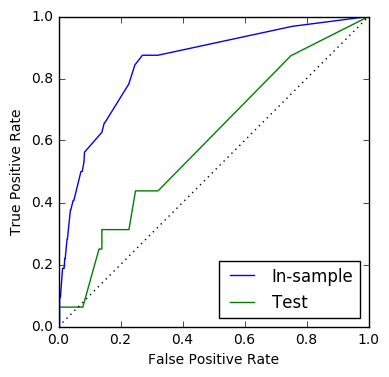

In [15]:
# Plot an ROC curve for training
plt.clf
pred_train = swl.predict_proba(X_train)
rocAUC_train = sklm.roc_auc_score(y_train,pred_train)
print('In-sample ROC AUC = %.3f ' % rocAUC_train)
fpr, tpr, _ = sklm.roc_curve(y_train, pred_train)
plt.figure()
plt.plot(fpr,tpr,label='In-sample')

# Plot an ROC curve for test data
pred_test = swl.predict_proba(X_test)
rocAUC_test = sklm.roc_auc_score(y_test,pred_test)
print('Test ROC AUC = %.3f ' % rocAUC_test)
fpr, tpr, _ = sklm.roc_curve(y_test, pred_test)
plt.plot(fpr,tpr,label='Test')

# Format the ROC plot
plt.plot([0, 1], [0, 1], color='k', linestyle=':')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='lower right')
plt.show()